In [1]:
import pymc as pm
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import matplotlib.cm as cm
import pandas as pd
import pytensor.tensor as pt
import json

#Make sure it can see the system path
from pathlib import Path
import sys

import sys
from pathlib import Path

PROJECT_ROOT = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))



In [2]:
def plot_posterior(trace,var_name,ax=None,**kwargs):
    if ax is None:
        ax=plt.subplot(111)
    data=getattr(trace.posterior,var_name).stack(sample=("chain","draw")).values
    sns.kdeplot(data,ax=ax,**kwargs)

In [3]:
from utils import load_data
#reload(load_data)

In [4]:
carbon_cycle_evidence=load_data.load_carbon_cycle()


In [5]:
feedback_evidence=load_data.feedback_dictionary(generation="CMIP6")

In [6]:
temperature_evidence={}
temperature_evidence["T2000"]=load_data.load_temperature(2000)

In [7]:
evidence = carbon_cycle_evidence | feedback_evidence | temperature_evidence

In [8]:
def build_fixed_effects_model(evidence: xr.DataArray,
    priors={},
    var_name="X"):
    data = evidence.values
    with pm.Model() as model:
        # true value of the parameter we want to estimate
        if "X" in priors.keys():
            X_true = priors["X"](var_name)
        else:
            X_true=pm.Normal(var_name,0,100)
        if "sigma" in priors.keys():
            sigma = priors["sigma"]("sigma")
        else:
            sigma= pm.HalfNormal("sigma",1.0)
        pm.Normal("likelihood",X_true,sigma,observed=data)
    return model

In [9]:

def build_random_effects_model(data: xr.DataArray,
    priors={},
    var_name="X"):
    
    evidence_stacked = data.stack(run=("model",))
    
    # Unique models
    unique_models = np.unique(data.model.values)
    nmodels=len(unique_models)


    # Map model names to integers
    model_to_int = {name: i for i, name in enumerate(unique_models)}
    model_idx_int = np.array([model_to_int[m] for m in evidence_stacked["model"].values])
    with pm.Model(coords={"model": unique_models}) as vecmodel:
        
        # ======== Prior on the estimated quantity ============== #
        if var_name in priors.keys():
            X_true = priors[var_name](var_name)
        else:
            # Use a wide prior
            X_true = pm.Normal(var_name, 0, 100)
            
        # ======== Prior on CMIP structural spread ============== #
        if "sigma_struct" in priors.keys():
            sigma_struct = priors["sigma_struct"]("sigma_struct")
        else:
            sigma_struct = pm.HalfNormal("sigma_struct", 1.0)
            
         # ======== Prior on internal variability in each model =========#
        if "sigma_iv" in priors.keys():
            sigma_iv = priors["sigma_iv"]("sigma_iv")
        else:
            sigma_iv = pm.HalfNormal("sigma_iv", 1.0,dims=("model",))
        # Force it into a tensorvariable if it's a scalar
        sigma_iv = pt.as_tensor_variable(sigma_iv)


        # ======== Prior on correlation between biases =========#
        # for rho = constant, use priors["rho"] = lambda name: constant
        if "rho" in priors.keys():
            rho = priors["rho"]("rho")
        else:
            rho = pm.Beta("rho", alpha=5, beta=5)
        # Force it into a tensorvariable if it's a scalar
        rho = pt.as_tensor_variable(rho)

        # ======== Generate the correlation matrix =========#
        I = pt.eye(nmodels)
        J = pt.ones((nmodels, nmodels))
        corr = (1 - rho) * I + rho * J

        # Cholesky factor for speed
        chol = sigma_struct * pt.linalg.cholesky(corr)

        # Latent correlated model means X_m ~ MN(X_true,σ_struct x (1-ρ)I+ρJ)
        X_m = pm.MvNormal(
            "X_m",
            mu=X_true * pt.ones(nmodels),
            chol=chol,
            dims="model",
        )

        # ======== Within-ensemble internal variability =========#
        # vectorized likelihood using integer index
        if len(sigma_iv.shape.eval()) > 0:
            pm.Normal(
                f"{var_name}_lik",
                mu=X_m[model_idx_int],
                sigma=sigma_iv[model_idx_int],
                observed=evidence_stacked.values,
            )
        else:
            pm.Normal(
                f"{var_name}_lik",
                mu=X_m[model_idx_int],
                sigma=sigma_iv,
                observed=evidence_stacked.values,
            )
    return vecmodel
    


In [10]:
# calculate trace for rho = 0
var_name="T2000"
priors0={}
priors0["rho"] = lambda name:0.0
with build_random_effects_model(data = evidence[var_name],priors=priors0,var_name=var_name) as model_0:
    trace_0=pm.sample(target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T2000, sigma_struct, sigma_iv, X_m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


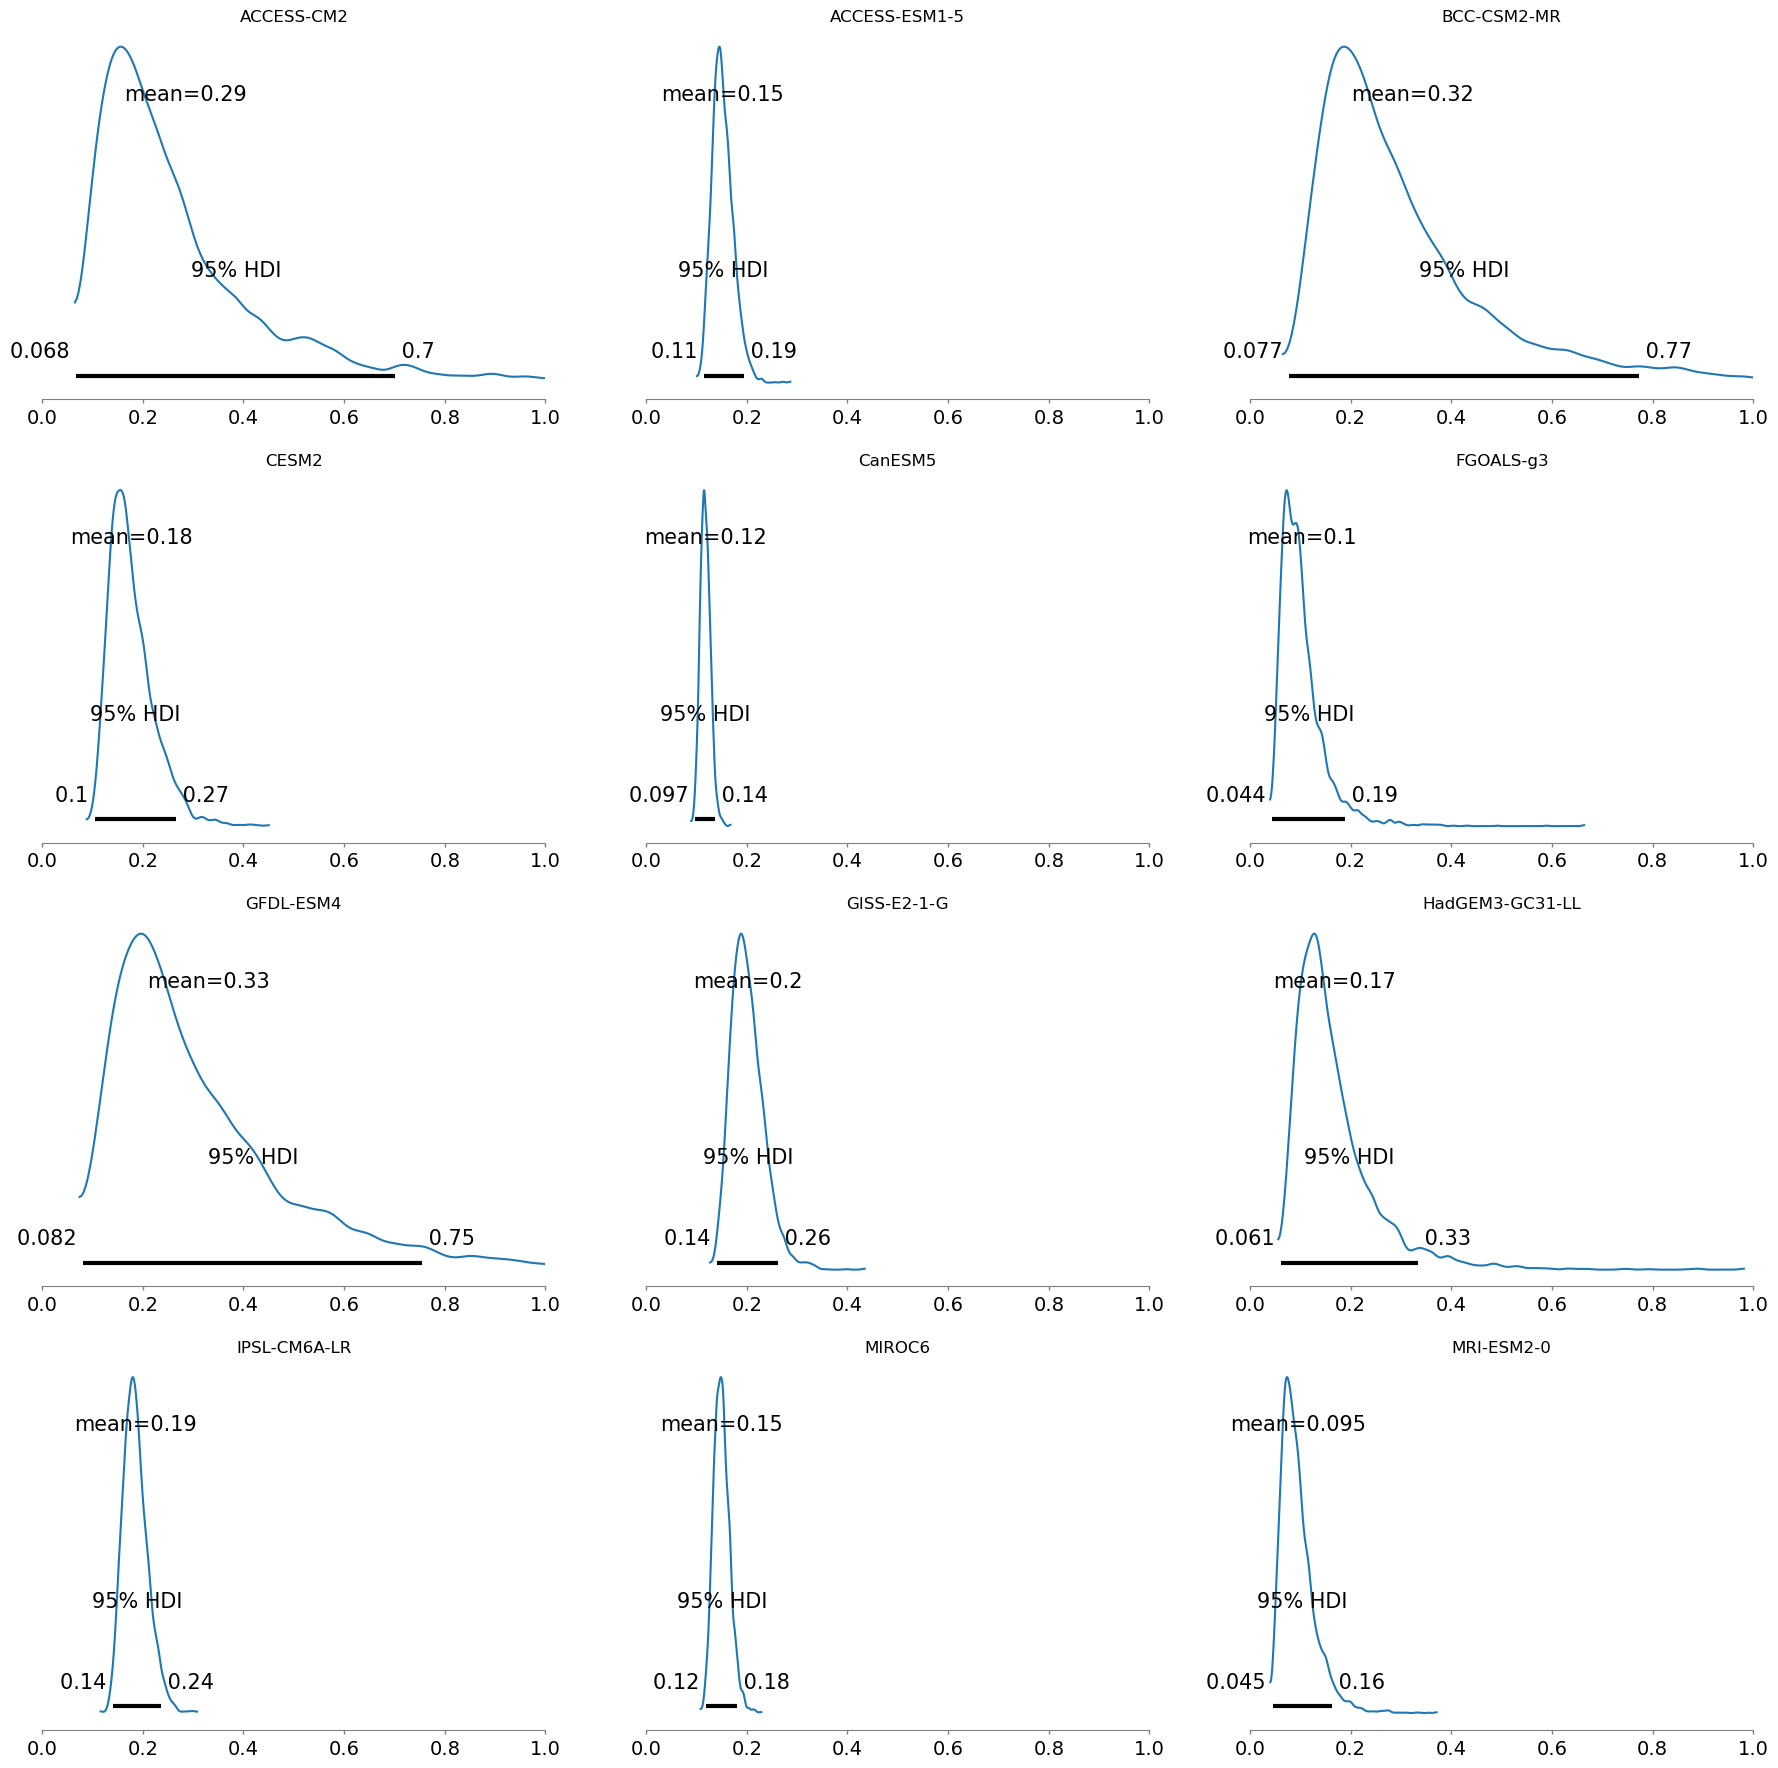

In [560]:
axes=az.plot_posterior(trace_default,var_names=["sigma_iv"],kind="kde",hdi_prob=.95)
for ax in axes.flatten():
    ax.set_title(ax.get_title().split("\n")[1])
    ax.set_xlim(0,1)

In [16]:
with build_fixed_effects_model(evidence["T2000"],var_name="T2000") as fixmodel:
    trace_fix=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T2000, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


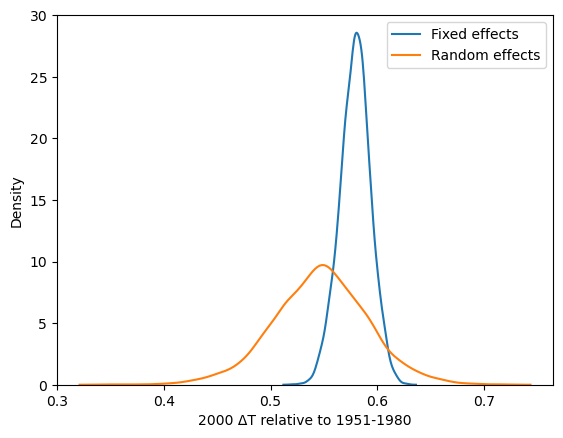

In [17]:
plot_posterior(trace_fix,var_name,label="Fixed effects")
plot_posterior(trace_0,var_name,label="Random effects")
plt.xlabel("2000 ΔT relative to 1951-1980")
plt.legend()
#sns.kdeplot(hadcrut_2000)

In [11]:
hadcrut_file=\
"/Users/kmarvel/Documents/Attribution/DATA/Observations/HadCRUT.5.0.2.0.analysis.ensemble_series.global.annual.nc"
hadcrut=xr.open_dataset(hadcrut_file).tas

<Axes: ylabel='Density'>

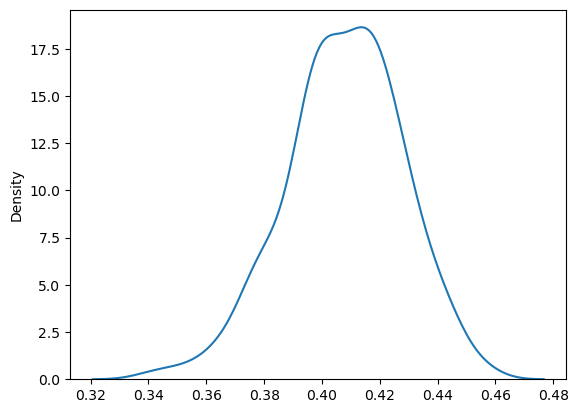

In [12]:
hadcrut_2000=hadcrut.sel(time=slice("2000-1-1","2000-12-31")).mean(dim="time")-\
hadcrut.sel(time=slice("1951-1-1","1980-12-31")).mean(dim="time")
sns.kdeplot(hadcrut_2000)


/Users/kmarvel/miniconda3/envs/cmip_bayes/lib/python3.11/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


<Axes: >

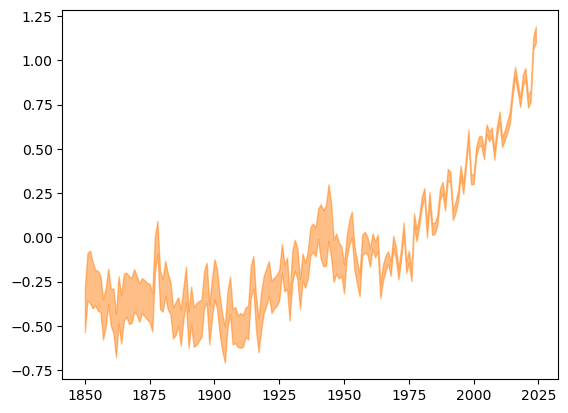

In [15]:
az.plot_hdi(1850+np.arange(len(hadcrut.time.values)),hadcrut.values,smooth=False)


(array([ 3.,  8., 21., 20., 33., 34., 34., 29., 11.,  7.]),
 array([0.29055238, 0.29813647, 0.30572057, 0.31330466, 0.32088875,
        0.32847284, 0.33605693, 0.34364102, 0.35122512, 0.35880921,
        0.3663933 ]),
 <BarContainer object of 10 artists>)

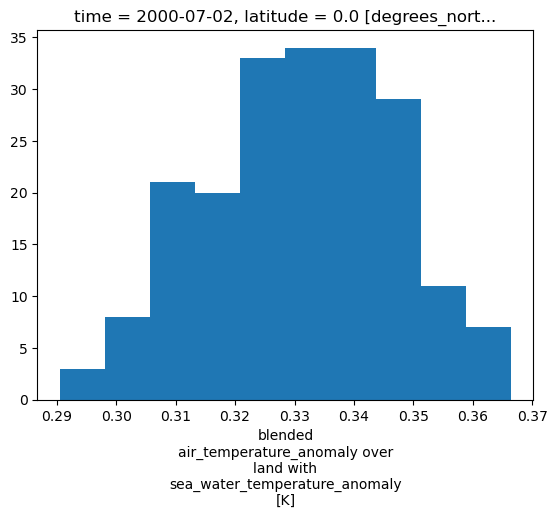

In [638]:
hadcrut.sel(time="2000-7-1",method="nearest").plot.hist()

# ECS

In [19]:
def use_noncentered(mu_iv, priors):
    # If IV is marginalized → non-centered is good
    if mu_iv is not None:
        return True

    # If sigma_iv is fixed to a small constant → centered is better
    if "sigma_iv" in priors:
        try:
            test = priors["sigma_iv"]("test")
            if np.isscalar(test) and test < 0.2:
                return False
        except Exception:
            pass

    # Default
    return True

In [24]:

def test_build(data: xr.DataArray,
    priors={},
    var_name="X",
    mu_iv=None):
    
    evidence_stacked = data.stack(run=("model",))
    
    # Unique models
    unique_models = np.unique(data.model.values)
    nmodels=len(unique_models)


    # Map model names to integers
    model_to_int = {name: i for i, name in enumerate(unique_models)}
    model_idx_int = np.array([model_to_int[m] for m in evidence_stacked["model"].values])
    with pm.Model(coords={"model": unique_models}) as vecmodel:
        
        # ======== Prior on the estimated quantity ============== #
        if var_name in priors.keys():
            X_true = priors[var_name](var_name)
        else:
            # Use a wide prior
            X_true = pm.Normal(var_name, 0, 100)
            
        # ======== Prior on CMIP structural spread ============== #
        if "sigma_struct" in priors.keys():
            sigma_struct = priors["sigma_struct"]("sigma_struct")
        else:
            sigma_struct = pm.HalfNormal("sigma_struct", 1.0)
            
         # ======== Prior on internal variability in each model =========#
        if mu_iv is None:
            # If mu_iv is specified, we assume sigma~iv,m ~ LogNormal(mu_iv,tau)
            # We then have y_m | X_m ~ StudentT
            #This is useful in cases where the uncertainty in iv is completely prior-dominated

            if "sigma_iv" in priors.keys():
                sigma_iv = priors["sigma_iv"]("sigma_iv")
            else:
                #Otherwise use a HalfNormal for sigma_iv
                sigma_iv = pm.HalfNormal("sigma_iv",
                                         1.0,
                                        dims="model")
            # Force it into a tensorvariable if it's a scalar
            sigma_iv = pt.as_tensor_variable(sigma_iv)


        # ======== Prior on correlation between biases =========#
        # for rho = constant, use priors["rho"] = lambda name: constant
        if "rho" in priors.keys():
            rho = priors["rho"]("rho")
        else:
            rho = pm.Beta("rho", alpha=5, beta=5)
        # Force it into a tensorvariable if it's a scalar
        rho = pt.as_tensor_variable(rho)

        # ======== Generate the correlation matrix =========#
        I = pt.eye(nmodels)
        J = pt.ones((nmodels, nmodels))
        corr = (1 - rho) * I + rho * J

        # Cholesky factor for speed
        #chol = sigma_struct * pt.linalg.cholesky(corr)
        chol_corr = pt.linalg.cholesky(corr)
        
        use_nc = use_noncentered(mu_iv, priors)

        # ======== Latent model means ======== #
        if use_nc:
            # ---- Non-centered ----
            z_m = pm.Normal("z_m", 0, 1, dims="model")

            X_m = pm.Deterministic(
                f"{var_name}_CMIP",
                X_true + sigma_struct * pt.dot(chol_corr, z_m),
                dims=("model",)
            )

        else:
            # ---- Centered ----
            X_m = pm.MvNormal(
                f"{var_name}_CMIP",
                mu=X_true * pt.ones(nmodels),
                chol=sigma_struct * chol_corr,
                dims=("model",)
            )

         # ======== Within-ensemble internal variability =========#
        # vectorized likelihood using integer index
        if mu_iv is not None:
            nu = 4

            pm.StudentT(
                f"{var_name}_lik",
                mu=X_m[model_idx_int],
                sigma=mu_iv,
                nu=nu,
                observed=evidence_stacked.values,
            )
        else:
            if len(sigma_iv.shape.eval()) > 0:
                pm.Normal(
                    f"{var_name}_lik",
                    mu=X_m[model_idx_int],
                    sigma=sigma_iv[model_idx_int],
                    observed=evidence_stacked.values,
                )
            else:
                pm.Normal(
                    f"{var_name}_lik",
                    mu=X_m[model_idx_int],
                    sigma=sigma_iv,
                    observed=evidence_stacked.values,
                )
    return vecmodel
    


In [30]:
priors_ECS={}
priors_ECS["sigma_iv"] = lambda name:0.05
with test_build(evidence["ECS"],var_name="ECS",priors=priors_ECS):
    default_ECS = pm.sample(target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, sigma_struct, rho, ECS_CMIP]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<Axes: title={'center': 'ECS_CMIP'}>

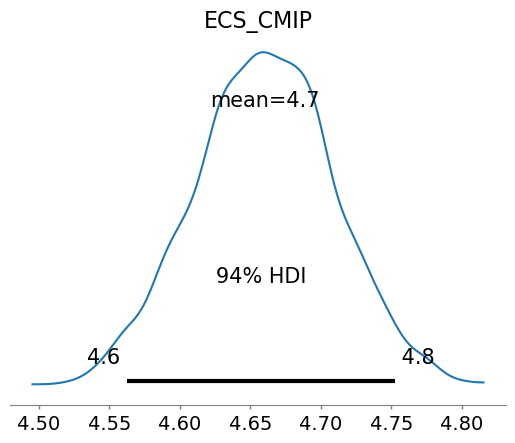

In [34]:
az.plot_posterior(default_ECS.posterior.ECS_CMIP.isel(model=0))

In [579]:
priors_ECS_0={}
priors_ECS_0["sigma_iv"]=lambda name:.01
priors_ECS_0["rho"] =lambda name:0.
with build_random_effects_model(evidence["ECS"],var_name="ECS",priors=priors_ECS_0):
    ECS_0 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, sigma_struct, X_m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [581]:
priors_ECS_05={}
priors_ECS_05["sigma_iv"]=lambda name:.01
priors_ECS_05["rho"] =lambda name:0.5
with build_random_effects_model(evidence["ECS"],var_name="ECS",priors=priors_ECS_05):
    ECS_05 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, sigma_struct, X_m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [585]:
priors_ECS_01={}
priors_ECS_01["sigma_iv"]=lambda name:.01
priors_ECS_01["rho"] =lambda name:0.1
with build_random_effects_model(evidence["ECS"],var_name="ECS",priors=priors_ECS_01):
    ECS_01 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, sigma_struct, X_m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


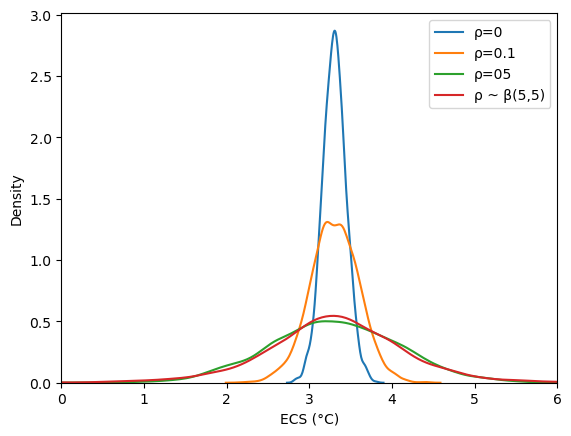

In [589]:
plot_posterior(ECS_0,"ECS",label="ρ=0")
plot_posterior(ECS_01,"ECS",label="ρ=0.1")
plot_posterior(ECS_05,"ECS",label="ρ=05")
plot_posterior(default_ECS,"ECS",label="ρ ~ β(5,5)")
plt.xlabel("ECS (°C)")
plt.xlim(0,6)
plt.legend()

Text(0.5, 0, 'ρ')

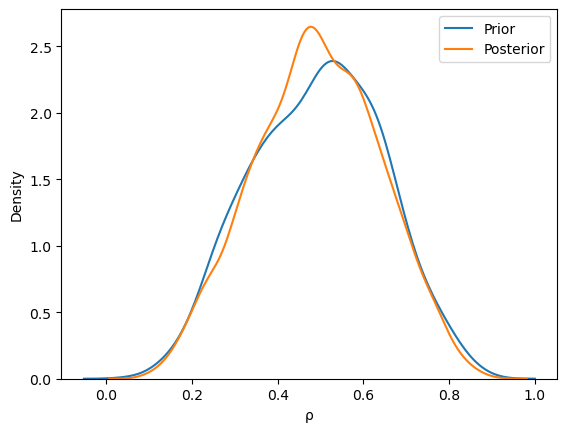

In [596]:

sns.kdeplot(stats.beta(5,5).rvs(1000),label="Prior")
plot_posterior(default_ECS,"rho",label="Posterior")
plt.legend()
plt.xlabel("ρ")

# TO DO:
* incorporate vectorized random effects model into build_random_bias_model
* incorporate vectorized random effects into correlated bias model
* compare for three cases: T2000 (where we have large ensembles), ECS (where we only have a few small "ensembles") and beta_land (no ensembles)
* Show the effects of including correlated biases
* present posteriors
* add emergent constraints
* Add direct observations


In [304]:
def build_correlated_bias_model(evidence: xr.DataArray,
    priors={},
    var_name="X"):
    # coords from xarray
    model_names = np.unique(evidence.coords["model"].values)
    Ldata = len(evidence.values)
    nmodels=len(model_names)

    coords = {"model": model_names,"CMIP_run":np.arange(Ldata)}

    with pm.Model(coords=coords) as bias_model:

        # true value of the parameter we want to estimate
        if "X" in priors.keys():
            X_true = priors["X"](var_name)
        else:
            X_true=pm.Normal(var_name,0,100)

        # Structural uncertainty in CMIP
        if "sigma_struct" in priors.keys():
            sigma_struct = priors["sigma_struct"]("sigma_struct")
        else:
            sigma_struct = pm.HalfNormal("sigma_struct",1.0)

        # Internal variability
        if "sigma_iv" in priors.keys():
            sigma_m = priors["sigma_iv"]("sigma_iv")
        else:
            sigma_m = pm.HalfNormal("sigma_iv",1.,dims="model")
        # Force it into a tensorvariable if it's a scalar
        sigma_m = pt.as_tensor_variable(sigma_m)
        
        # Prior on rho:
        if "rho" in priors.keys():
            rho = priors["rho"]("rho")
        else:
            rho = pm.Beta("rho", alpha=5, beta=5)
        # Force it into a tensorvariable if it's a scalar
        rho = pt.as_tensor_variable(rho)

        # Equicorrelation matrix
        I = pt.eye(nmodels)
        J = pt.ones((nmodels, nmodels))
        corr = (1 - rho) * I + rho * J

        # Cholesky factor
        chol = sigma_struct * pt.linalg.cholesky(corr)

        # Latent correlated model means
        X_m = pm.MvNormal(
            "X_m",
            mu=X_true * pt.ones(nmodels),
            chol=chol,
            dims="model",
        )
        
        for i,ESM in enumerate(coords["model"]):
            obs=evidence.sel(model=ESM).values
            if obs.shape == ():
                obs=[float(obs)]
            if len(sigma_m.shape.eval()) > 0:
                pm.Normal(f"X_{ESM}_lik",X_m[i],sigma_m[i],observed=evidence.sel(model=ESM).values)
            else:
                pm.Normal(f"X_{ESM}_lik",X_m[i],sigma_m,observed=evidence.sel(model=ESM).values)
            
        return bias_model   
            
            
            

In [371]:
var_name="T2000"
data=temperature_evidence["T2000"]
temp_priors={}

In [373]:
with build_correlated_bias_model_OLD(0,data,var_name=var_name):
    temp_RE=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T2000, sigma_struct, sigma_iv, T2000_CMIP]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [374]:
with build_fixed_effects_model(data,var_name=var_name):
    temp_fix=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T2000, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


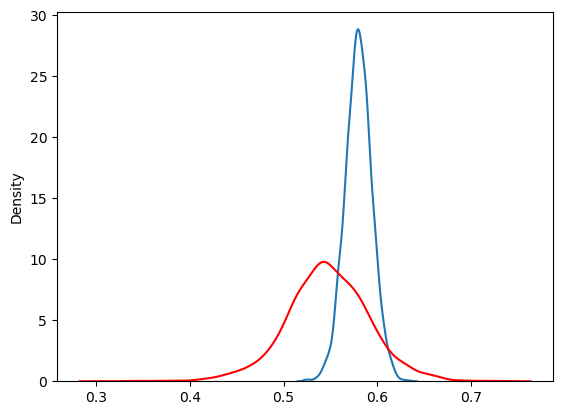

In [375]:
ax=plt.subplot(111)
plot_posterior(temp_fix,var_name,ax=ax,label="M1")
plot_posterior(temp_RE,var_name,ax=ax,label="M2",c="r")

In [482]:
var_name="betaL"
data = evidence[var_name]
evidence_stacked = data.stack(run=("model",))
coords = {"model": model_names,"CMIP_run":np.arange(Ldata)}


In [490]:

# Unique models
unique_models = np.unique(data.model.values)

# Map model names to integers
model_to_int = {name: i for i, name in enumerate(unique_models)}
model_idx_int = np.array([model_to_int[m] for m in evidence_stacked["model"].values])
with pm.Model(coords={"model": unique_models}) as vecmodel:

    X_true = pm.Normal(var_name, 0, 100)

    sigma_struct = pm.HalfNormal("sigma_struct", 1.0)
   # sigma_iv = pm.HalfNormal("sigma_iv", 0.05)
    sigma_iv=0.05

    X_m = pm.Normal(
        f"{var_name}_CMIP",
        mu=X_true,
        sigma=sigma_struct,
        dims="model",
    )

    # vectorized likelihood using integer index
    pm.Normal(
        f"{var_name}_lik",
        mu=X_m[model_idx_int],
        sigma=sigma_iv,
        observed=evidence_stacked.values,
    )
    vectrace=pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaL, sigma_struct, betaL_CMIP]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([<Axes: title={'center': 'betaL'}>,
       <Axes: title={'center': 'sigma_struct'}>], dtype=object)

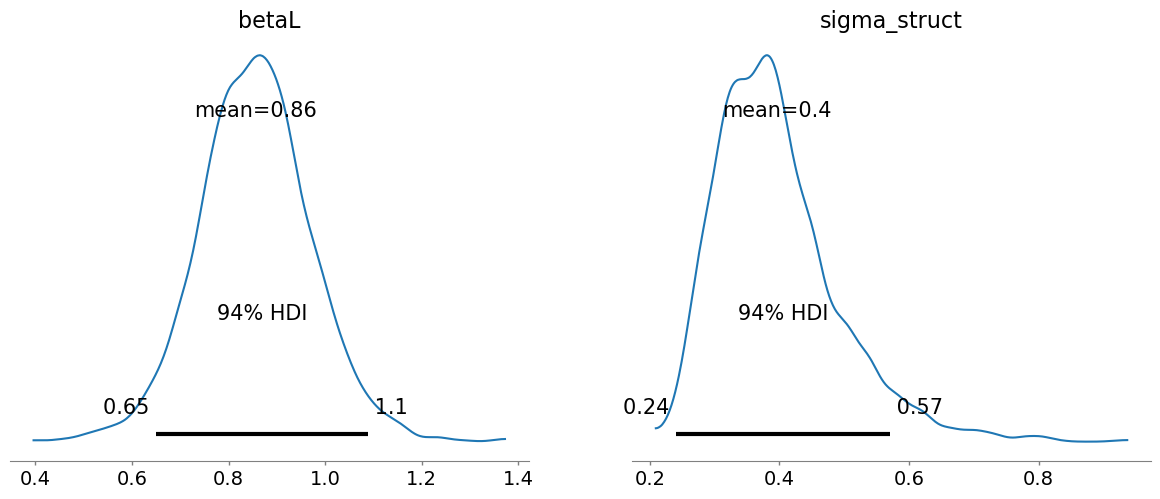

In [493]:
az.plot_posterior(vectrace,var_names=[var_name,"sigma_struct"])

In [488]:
with build_fixed_effects_model(data,var_name=var_name):
    fixtrace=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaL, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: title={'center': 'betaL'}>

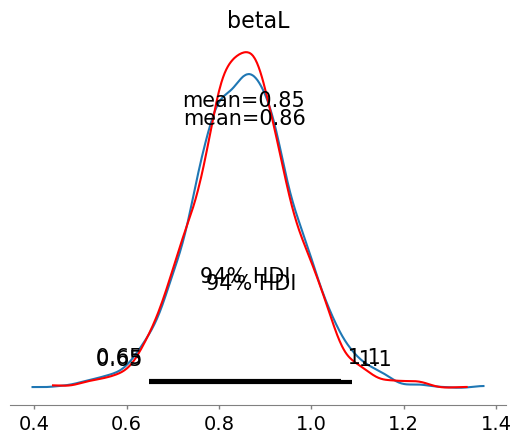

In [492]:
az.plot_posterior(vectrace.posterior,var_names=[var_name])
az.plot_posterior(fixtrace.posterior,var_names=[var_name],ax=plt.gca(),c="r")

In [428]:
def build_random_bias_model(
    evidence: xr.DataArray,
    priors={},
    var_name="X"
):
    # coords from xarray
    model_names = np.unique(evidence.coords["model"].values)
    Ldata = len(evidence.values)
    nmodels=len(model_names)

    
    evidence_stacked = evidence.stack(run=("model",))
    coords = {"model": model_names,"CMIP_run":np.arange(Ldata)}

    with pm.Model(coords=coords) as bias_model:

        # true value of the parameter we want to estimate
        if "X" in priors.keys():
            X_true = priors["X"](var_name)
        else:
            X_true=pm.Normal(var_name,0,100)

        # Structural uncertainty in CMIP
        if "sigma_struct" in priors.keys():
            sigma_struct = priors["sigma_struct"]("sigma_struct")
        else:
            sigma_struct = pm.HalfNormal("sigma_struct",1.0)

        # Internal variability
        if "sigma_iv" in priors.keys():
            sigma_iv = priors["sigma_iv"]("sigma_iv")
        else:
            sigma_iv = pm.HalfNormal("sigma_iv",1.,dims="model")
        # Force it into a tensorvariable if it's a scalar
        sigma_iv = pt.as_tensor_variable(sigma_iv)
        

        # Independent latent X_m
        X_m = pm.Normal(
            f"{var_name}_CMIP",
            mu=X_true,
            sigma=sigma_struct,
            dims="model",
        )
  
        for i,ESM in enumerate(coords["model"]):
            #print(i,ESM)
            obs = evidence.sel(model=ESM).values
            obs = np.atleast_1d(obs)
#             if obs.shape == ():
#                 obs=[float(obs)]
            if len(sigma_iv.shape.eval()) > 0:
                #print("vector sigma_iv")
                pm.Normal(f"X_{ESM}_lik",X_m[i],sigma_iv[i],observed=evidence.sel(model=ESM).values)
            else:
                #print("scalar sigma_iv")
                pm.Normal(f"X_{ESM}_lik",X_m[i],sigma_iv,observed=evidence.sel(model=ESM).values)
            
        return bias_model   
            
            
            

In [418]:
var_name="T2000"
data=temperature_evidence["T2000"]
ecs_priors={}
ecs_priors["sigma_iv"] = lambda name:pm.HalfNormal(name,0.1)
with build_random_bias_model(data,var_name=var_name,priors=ecs_priors):
    T_RE=pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T2000, sigma_struct, sigma_iv, T2000_CMIP]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [443]:
for esm in np.unique(data.model.values):
    print(data.sel(model=esm).shape)

()
()
()
()
()
(2,)
()
()
()
()
()
()
()
()
()
(2,)
(2,)
()
()
()
()
()
()
(3,)
()
()
()
(4,)
(2,)
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
(6,)
()
()
()
()
()
()
()


In [422]:
temperature_evidence["T2000"]

<xarray.DataArray (model: 238)>
array([0.74023438, 0.42550659, 0.55102539, 0.36557007, 0.67828369,
       0.3888855 , 0.63549805, 0.2868042 , 0.53082275, 0.47106934,
       0.36123657, 0.28170776, 0.19268799, 0.47924805, 0.70678711,
       0.4866333 , 0.52383423, 0.45507812, 0.34405518, 0.49249268,
       0.63726807, 0.41625977, 0.34341431, 0.28250122, 0.46575928,
       0.45501709, 0.64904785, 0.40823364, 0.68341064, 0.49057007,
       0.26898193, 0.75363159, 0.47625732, 0.82662964, 0.54672241,
       0.45916748, 0.73861694, 0.88461304, 0.55899048, 0.46289062,
       0.41812134, 0.60232544, 0.45910645, 0.52511597, 0.38201904,
       0.38851929, 0.44177246, 0.87097168, 0.71975708, 0.78234863,
       0.63647461, 0.83514404, 0.81298828, 0.78808594, 0.74813843,
       0.64385986, 0.61102295, 0.94921875, 0.86431885, 0.80905151,
       0.93157959, 0.75723267, 0.73635864, 0.76489258, 0.74316406,
       0.72531128, 1.07839966, 1.07397461, 0.61624146, 0.92364502,
       0.81759644, 0.71401978, 0.81713867, 0.7822876 , 0.72131348,
       0.81655884, 0.9442749 , 0.91842651, 0.9493103 , 0.75595093,
       0.84860229, 0.79144287, 0.88772583, 0.62698364, 0.89657593,
       0.95849609, 0.7817688 , 0.71276855, 0.64508057, 0.73934937,
       0.76855469, 0.87286377, 1.02960205, 0.9475708 , 0.75405884,
       0.79260254, 0.90783691, 0.86828613, 0.98474121, 0.78051758,
...
       0.61861144, 0.64602232, 0.51059125, 0.40615714, 0.46868896,
       0.4977417 , 0.6854248 , 0.49154663, 0.3578186 , 0.4699707 ,
       0.48510742, 0.70620728, 0.52972412, 0.29956055, 0.81707764,
       0.57415771, 0.75415039, 0.54177856, 0.72915649, 0.41558838,
       0.61407471, 0.81747437, 0.63137817, 0.80813599, 0.68960571,
       0.49279785, 0.43435669, 0.53900146, 0.60565186, 0.50683594,
       0.69769287, 0.32818604, 0.4546814 , 0.60958862, 1.16195679,
       0.65966797, 0.62249756, 0.49160767, 0.89511108, 0.77642822,
       0.76904297, 0.3086853 , 0.57592773, 0.46664429, 0.38931274,
       0.5513916 , 0.16659546, 0.33700562, 0.33920288, 0.47015381,
       0.34463501, 0.17822266, 0.62426758, 0.3260498 , 0.24456787,
       0.26068115, 0.25546265, 0.64559937, 0.48764038, 0.37631226,
       0.63256836, 0.27923584, 0.27078247, 0.25192261, 0.71310425,
       0.37298584, 0.36700439, 0.21182251, 0.38284302, 0.30123901,
       0.39660645, 0.61737061, 0.5319519 , 0.32550049, 0.29699707,
       0.43011475, 0.36611938, 0.67565918, 0.37896729, 0.05709839,
       0.15710449, 0.52932739, 0.42849731, 0.27490234, 0.38012695,
       0.25714111, 0.40170288, 0.32171631, 0.49603271, 0.43518066,
       0.22579956, 0.60519409, 0.6111145 , 0.46426392, 0.48364258,
       0.41845703, 0.5383606 , 0.58047485])
Coordinates:
  * model    (model) <U15 'ACCESS-CM2' 'ACCESS-CM2' ... 'MRI-ESM2-0'

In [432]:
feedback_evidence["ECS"].model

<xarray.DataArray 'model' (model: 67)>
array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'BCC-ESM1', 'CAMS-CSM1-0', 'CAMS-CSM1-0', 'CESM2', 'CESM2-FV2',
       'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM', 'CMCC-CM2-SR5', 'CMCC-ESM2',
       'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CNRM-ESM2-1', 'CanESM5',
       'CanESM5', 'E3SM-1-0', 'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'FGOALS-f3-L',
       'FGOALS-f3-L', 'FGOALS-g3', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G',
       'GISS-E2-1-G', 'GISS-E2-1-G', 'GISS-E2-1-G', 'GISS-E2-1-H',
       'GISS-E2-1-H', 'GISS-E2-2-G', 'GISS-E2-2-H', 'HadGEM3-GC31-LL',
       'HadGEM3-GC31-MM', 'IITM-ESM', 'INM-CM4-8', 'INM-CM5-0',
       'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR', 'IPSL-CM6A-LR-INCA', 'KACE-1-0-G',
       'MIROC-ES2L', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'MRI-ESM2-0', 'MRI-ESM2-0', 'MRI-ESM2-0',
       'MRI-ESM2-0', 'MRI-ESM2-0', 'NESM3', 'NorCPM1', 'NorESM2-LM',
       'NorESM2-MM', 'SAM0-UNICON', 'TaiESM1', 'UKESM1-0-LL'], dtype='<U17')
Coordinates:
  * model    (model) <U17 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'

In [429]:
var_name="ECS"
data=feedback_evidence["ECS"]
ecs_priors={}
ecs_priors["sigma_iv"] = lambda name:pm.HalfNormal(name,0.1)
with build_random_bias_model(data,var_name=var_name,priors=ecs_priors):
    ecs_RE=pm.sample()
    


You can find the C code in this temporary file: /var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/pytensor_compilation_error_0d703u2p


CompileError: Compilation failed (return status=1):
/usr/bin/clang++ -dynamiclib -g -O3 -fno-math-errno -Wno-unused-label -Wno-unused-variable -Wno-write-strings -Wno-c++11-narrowing -fno-exceptions -fno-unwind-tables -fno-asynchronous-unwind-tables -DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -fPIC -undefined dynamic_lookup -I/Users/kmarvel/miniconda3/envs/cmip_bayes/lib/python3.11/site-packages/numpy/core/include -I/Users/kmarvel/miniconda3/envs/cmip_bayes/include/python3.11 -I/Users/kmarvel/miniconda3/envs/cmip_bayes/lib/python3.11/site-packages/pytensor/link/c/c_code -L/Users/kmarvel/miniconda3/envs/cmip_bayes/lib -fvisibility=hidden -o /Users/kmarvel/.pytensor/compiledir_macOS-15.7.1-arm64-arm-64bit-arm-3.11.3-64/tmp2cvna762/m808a83b3e727255077ba7812dd66f008677a0ac25637a0426ad34ae817e08942.so /Users/kmarvel/.pytensor/compiledir_macOS-15.7.1-arm64-arm-64bit-arm-3.11.3-64/tmp2cvna762/mod.cpp
/Users/kmarvel/.pytensor/compiledir_macOS-15.7.1-arm64-arm-64bit-arm-3.11.3-64/tmp2cvna762/mod.cpp:26386:32: fatal error: bracket nesting level exceeded maximum of 256
 26386 |         if (!PyErr_Occurred()) {
       |                                ^
/Users/kmarvel/.pytensor/compiledir_macOS-15.7.1-arm64-arm-64bit-arm-3.11.3-64/tmp2cvna762/mod.cpp:26386:32: note: use -fbracket-depth=N to increase maximum nesting level
1 error generated.

Apply node that caused the error: Composite{...}(sigma_iv_log__, X_UKESM1-0-LL_lik{5.359162439690016}, Subtensor{i}.0, 0, X_TaiESM1_lik{4.35549010691132}, Subtensor{i}.0, X_SAM0-UNICON_lik{3.7228789302772793}, Subtensor{i}.0, X_NorESM2-MM_lik{2.486771580097913}, Subtensor{i}.0, X_NorESM2-LM_lik{2.563222928994724}, Subtensor{i}.0, X_NorCPM1_lik{3.0317257208870005}, Subtensor{i}.0, X_NESM3_lik{4.764447107393327}, Subtensor{i}.0, X_MPI-ESM1-2-LR_lik{3.0254401947450527}, Subtensor{i}.0, X_MPI-ESM1-2-HR_lik{2.9797516932086876}, Subtensor{i}.0, X_MPI-ESM-1-2-HAM_lik{2.954485561926625}, Subtensor{i}.0, X_MIROC6_lik{2.601790969650521}, Subtensor{i}.0, X_MIROC-ES2L_lik{2.6605264351565174}, Subtensor{i}.0, X_KACE-1-0-G_lik{4.749146322262604}, Subtensor{i}.0, X_IPSL-CM6A-LR-INCA_lik{4.132670964390596}, Subtensor{i}.0, X_IPSL-CM6A-LR_lik{4.699160878253567}, Subtensor{i}.0, X_IPSL-CM5A2-INCA_lik{3.8166951335735537}, Subtensor{i}.0, X_INM-CM5-0_lik{1.9158220047671057}, Subtensor{i}.0, X_INM-CM4-8_lik{1.8271399573607425}, Subtensor{i}.0, X_IITM-ESM_lik{2.368209687987923}, Subtensor{i}.0, X_HadGEM3-GC31-MM_lik{5.439908226028159}, Subtensor{i}.0, X_HadGEM3-GC31-LL_lik{5.545597990718868}, Subtensor{i}.0, X_GISS-E2-2-H_lik{2.68011941553966}, Subtensor{i}.0, X_GISS-E2-2-G_lik{2.426388636618807}, Subtensor{i}.0, X_GFDL-ESM4_lik{2.649326318372123}, Subtensor{i}.0, X_GFDL-CM4_lik{3.89012524170708}, Subtensor{i}.0, X_FGOALS-g3_lik{2.870329852850268}, Subtensor{i}.0, X_EC-Earth3-Veg-LR_lik{4.231888886346553}, Subtensor{i}.0, X_EC-Earth3-Veg_lik{4.331213011183422}, Subtensor{i}.0, X_EC-Earth3-CC_lik{4.230871276276654}, Subtensor{i}.0, X_EC-Earth3-AerChem_lik{3.8686131128421866}, Subtensor{i}.0, X_EC-Earth3_lik{4.2600669989023405}, Subtensor{i}.0, X_E3SM-1-0_lik{5.306589770613417}, Subtensor{i}.0, X_CNRM-CM6-1-HR_lik{4.327072882761777}, Subtensor{i}.0, X_CNRM-CM6-1_lik{4.9036506204610255}, Subtensor{i}.0, X_CMCC-ESM2_lik{3.5768891864676724}, Subtensor{i}.0, X_CMCC-CM2-SR5_lik{3.553348106571406}, Subtensor{i}.0, X_CIESM_lik{5.632439077197677}, Subtensor{i}.0, X_CESM2-WACCM-FV2_lik{4.79855538768658}, Subtensor{i}.0, X_CESM2-WACCM_lik{4.684285678187821}, Subtensor{i}.0, X_CESM2-FV2_lik{5.164626628936494}, Subtensor{i}.0, X_CESM2_lik{5.147915202979365}, Subtensor{i}.0, X_BCC-ESM1_lik{3.254720038664252}, Subtensor{i}.0, X_BCC-CSM2-MR_lik{3.0193806981573683}, Subtensor{i}.0, X_AWI-CM-1-1-MR_lik{3.1605068525158244}, Subtensor{i}.0, X_ACCESS-ESM1-5_lik{3.8839034758064814}, Subtensor{i}.0, X_ACCESS-CM2_lik{4.66200640987198}, Subtensor{i}.0, 10.0, 0.0, Sum{axes=None}.0, Sum{axes=None}.0, Sum{axes=None}.0, Sum{axes=None}.0, Sum{axes=None}.0, Sum{axes=None}.0, Sum{axes=None}.0, -inf, 0.9189385332046727, -0.5, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 0.9189385332046727, 2.076793740349318, -100.0)
Toposort index: 74
Inputs types: [TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(int8, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float32, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float32, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=())]

HINT: Use a linker other than the C linker to print the inputs' shapes and strides.
HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [378]:
with build_fixed_effects_model(data,var_name=var_name,priors=ecs_priors):
    ecs_fix=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


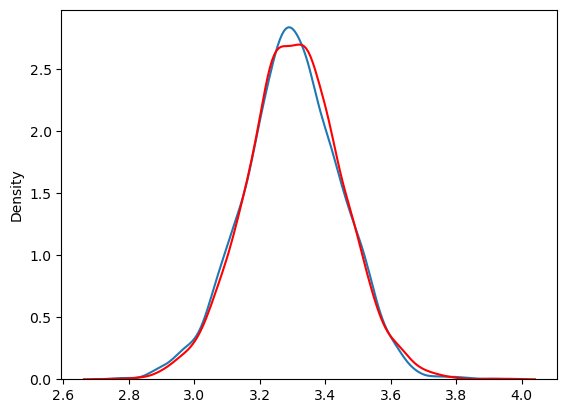

In [383]:
ax=plt.subplot(111)
plot_posterior(ecs_fix,var_name,ax=ax,label="M1")
plot_posterior(ecs_RE,var_name,ax=ax,label="M2",c="r")

In [338]:
var_name="T2000"
data=temperature_evidence["2000"]
temp_priors=

with build_correlated_bias_model(feedback_evidence["ECS"],var_name="ECS"):
    REtracepost=pm.sample(target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, sigma_struct, sigma_iv, rho, X_m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 580 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.


In [365]:
len(feedback_evidence["ECS"].data)

29

In [354]:
ecspriors={}
ecspriors["sigma_iv"]=lambda name: 0.1
with build_correlated_bias_model_OLD(0,feedback_evidence["ECS"],var_name="ECS",priors=ecspriors):
    REtrace=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, sigma_struct, ECS_CMIP]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [355]:
with build_fixed_effects_model(feedback_evidence["ECS"],var_name="ECS",priors=ecspriors):
    fixtrace=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


In [347]:
def plot_posterior(trace,var_name,ax=None,**kwargs):
    if ax is None:
        ax=plt.subplot(111)
    data=getattr(trace.posterior,var_name).stack(sample=("chain","draw")).values
    sns.kdeplot(data,ax=ax,**kwargs)

<Axes: title={'center': 'sigma'}>

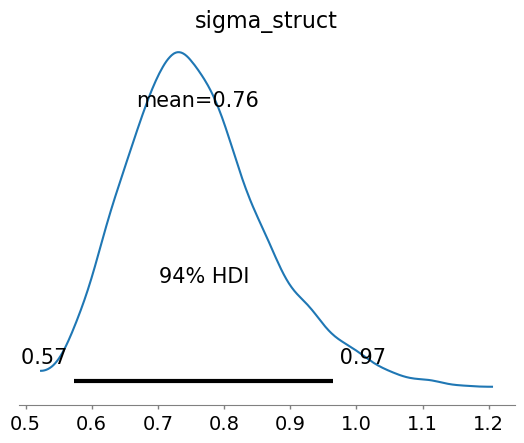

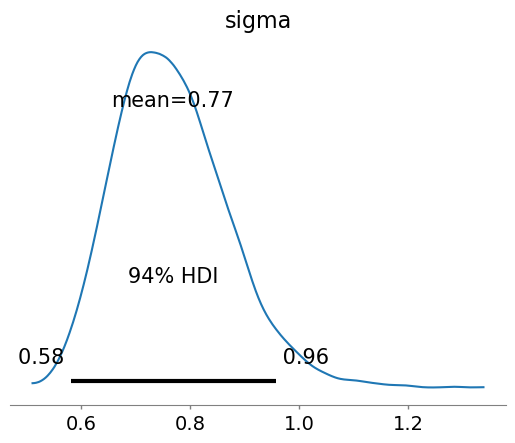

In [360]:
az.plot_posterior(REtrace.posterior.sigma_struct)
az.plot_posterior(fixtrace.posterior.sigma)

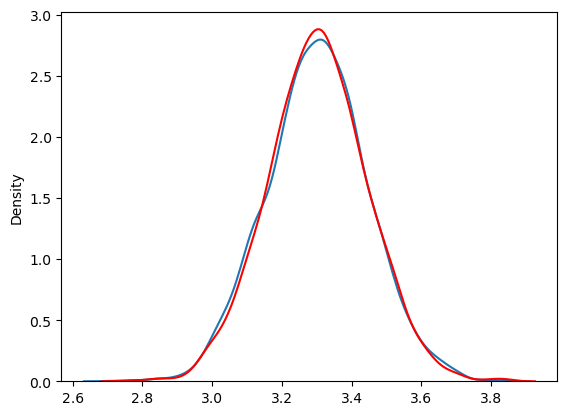

In [361]:
ax=plt.subplot(111)
plot_posterior(fixtrace,"ECS",ax=ax,label="M1")
plot_posterior(REtrace,"ECS",ax=ax,label="M2",c="r")
#plot_posterior(REtracepost,"ECS",ax=ax,label="M3",c="g")

In [274]:
mypriors={}
mypriors["sigma_iv"] = lambda name: .01
with build_correlated_bias_model(0.5,feedback_evidence["ECS"],var_name="ECS",priors=mypriors):
    REtrace05=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ECS, sigma_struct, X_m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [296]:
import scipy.stats as stats
scl95=stats.norm.interval(.95)[1]

<xarray.DataArray ()>
array(1.87508939) <xarray.DataArray ()>
array(4.73250524)


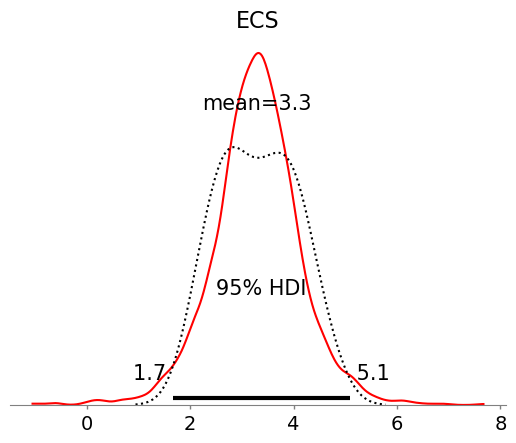

In [307]:
#az.plot_posterior(REtrace0.posterior.ECS)
#az.plot_posterior(REtrace05.posterior.ECS,ax=plt.gca(),c="g")
az.plot_posterior(REtracepost.posterior.ECS,ax=plt.gca(),c="r",hdi_prob=.95)
sns.kdeplot(feedback_evidence["ECS"],c='k',ls=":")
print(np.mean(feedback_evidence["ECS"])-scl95*np.std(feedback_evidence["ECS"]),\
     np.mean(feedback_evidence["ECS"])+scl95*np.std(feedback_evidence["ECS"]))

In [182]:
write_lookup_table=False
if write_lookup_table:
    cmip6_hasNitro = np.array([True, False, False, True, False, False, False, True, True, True, True, True, True])
    cmip6_hasPF = np.array([False, False, False, True, False, False, False, False, False, True, False, False, True])
    cmip6_hasFire = np.array([False, False, False, True, True, True, False, False, True, True, False, True, True])
    cmip6_hasDynveg = np.array([False, False, False, False, False, True, False, False, True, False, True, True, False])

    lookup_table=xr.DataArray(\
                              data=np.stack(\
                                            [cmip6_hasNitro,cmip6_hasPF,cmip6_hasFire,cmip6_hasDynveg]\
                                           ).astype(np.float32),\
                              coords={"process":["nitrogen","permafrost","fire","veg"],\
                                     "model":cmip6.model.values})
    lookup_table.to_netcdf("data/carbon_cycle/lookup_table.nc")
else:
    lookup_table=xr.open_dataarray("data/carbon_cycle/lookup_table.nc")

In [183]:
lookup_nitrogen=lookup_table.sel(process="nitrogen").values

In [199]:


def build_correlated_bias_model_with_process(
    rho_user,
    evidence: xr.DataArray,
    lookup_table,
    priors={},
    var_name="X",
):
    """
    rho_user: correlation between the bias in model i and the bias in model j
    
    evidence: must have coord "model" with list of model names
    
    lookup table: binary table of len(evidence) and coord "model".  1 if model has process, 0 otherwise
    
    priors: dict of priors with form priors["X"] = lambda name: pm.Normal(name,0,1) etc
    
    var_name: name of variable to estimate
    """
    model_names = np.unique(evidence.coords["model"].values)
    n = len(model_names)

    coords = {"model": model_names}

    y = evidence.sel(model=model_names).values
    has_process = np.asarray(lookup_table).astype(float)

    # multiplicative design vector: 1 or process scaling
    with pm.Model(coords=coords) as model:

        # ----- Unscaled mean -----
        X = priors["X"](f"{var_name}_unscaled") if "X" in priors \
        else pm.Normal(f"{var_name}_unscaled", 0.0, 10.0)

        # ----- Structural spread -----
        sigma_struct = (
            priors["sigma_struct"]("sigma_struct")
            if "sigma_struct" in priors
            else pm.HalfNormal("sigma_struct", 1.0)
        )

        # ----- Multiplicative process scaling -----
        process_scaling = (
            priors["process_scaling"]("process_scaling")
            if "process_scaling" in priors
            else pm.LogNormal("process_scaling", 0.0, 0.5)
        )
        
        # ----- Process-scaled X -----
        Xscaled = pm.Deterministic(var_name,process_scaling*X)
        
        # ----- Internal variability -----
        sigma_iv = pm.HalfNormal("sigma_iv", 0.1)

        # ----- Mean vector -----
        scale = 1.0 + has_process * (process_scaling - 1.0)
        mu = X * scale

        # ----- Equicorrelated structural covariance -----
        # Σ_struct = σ^2 [ (1−ρ) I + ρ 11ᵀ ]
        I = pt.eye(n)
        J = pt.ones((n, n))

        Sigma_struct = sigma_struct**2 * ((1.0 - rho_user) * I + rho_user * J)

        # Apply multiplicative scaling: D Σ D
        D = pt.diag(scale)
        Sigma = D @ Sigma_struct @ D + sigma_iv**2 * I

        # ----- Marginal likelihood -----
        pm.MvNormal(
            "X_obs",
            mu=mu,
            cov=Sigma,
            observed=y,
            dims="model",
        )

    return model


In [202]:
mypriors={}

mypriors["X"] = lambda name: pm.Normal(name,0,1)
with build_correlated_bias_model_with_process(
    0.5,
    carbon_cycle_evidence["betaL"],
    lookup_nitrogen,
    priors=mypriors,
    var_name="betaL"
):
    processtrace05=pm.sample(target_accept=.99,random_seed=2015)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaL_unscaled, sigma_struct, process_scaling, sigma_iv]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


<Axes: title={'center': 'betaL'}, ylabel='Density'>

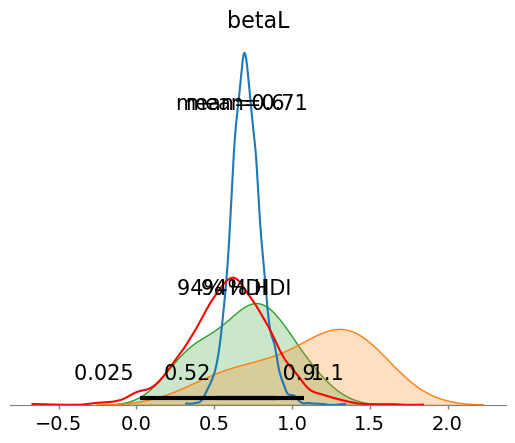

In [214]:
az.plot_posterior(processtrace.posterior.betaL)
az.plot_posterior(processtrace05.posterior.betaL,ax=plt.gca(),c="r")
sns.kdeplot(evidence["betaL"][np.where(lookup_nitrogen)],color=cm.tab10(2),fill=True)
sns.kdeplot(evidence["betaL"][np.where(lookup_nitrogen==0)],color=cm.tab10(1),fill=True)



# Why does the mean move?
Common biases amplify the contrast between process/no process groups.  It says both groups of ESMs have the same common bias.  So this shared bias can't explain the difference between the groups- it has to be explained via the unscaled B or the scaling factor.

# Why is the scaling factor the same in both $\rho=0$ and $\rho=.5$?
It's because of the model design.  The correlation (common biases among models) means it's easier to explain the differences between process and no-process by shifting the common unscaled X.  Changing the scaling factor only affects one group (the models WITH the process), which is penalized by the assumption of a common bias among ALL models.

<Axes: title={'center': 'betaL_unscaled'}>

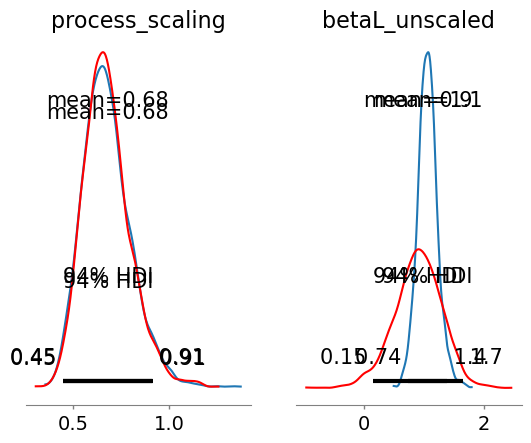

In [207]:
ax1=plt.subplot(121)
az.plot_posterior(processtrace.posterior.process_scaling,ax=ax1)
az.plot_posterior(processtrace05.posterior.process_scaling,ax=ax1,c="r")
ax2=plt.subplot(122)
az.plot_posterior(processtrace.posterior.betaL_unscaled,ax=ax2)
az.plot_posterior(processtrace05.posterior.betaL_unscaled,ax=ax2,c="r")

In [225]:


def test(
    evidence: xr.DataArray,
    lookup_table,
    priors={},
    var_name="X",
):
    """
   
    evidence: must have coord "model" with list of model names
    
    lookup table: binary table of len(evidence) and coord "model".  1 if model has process, 0 otherwise
    
    priors: dict of priors with form priors["X"] = lambda name: pm.Normal(name,0,1) etc
    
    var_name: name of variable to estimate
    """
    model_names = np.unique(evidence.coords["model"].values)
    n = len(model_names)

    coords = {"model": model_names}

    y = evidence.sel(model=model_names).values
    has_process = np.asarray(lookup_table).astype(float)

    # multiplicative design vector: 1 or process scaling
    with pm.Model(coords=coords) as model:
        rho_user = pm.TruncatedNormal("rho",.5,.2,lower=0,upper=1)

        # ----- Unscaled mean -----
        X = priors["X"](f"{var_name}_unscaled") if "X" in priors \
        else pm.Normal(f"{var_name}_unscaled", 0.0, 10.0)

        # ----- Structural spread -----
        sigma_struct = (
            priors["sigma_struct"]("sigma_struct")
            if "sigma_struct" in priors
            else pm.HalfNormal("sigma_struct", 1.0)
        )

        # ----- Multiplicative process scaling -----
        process_scaling = (
            priors["process_scaling"]("process_scaling")
            if "process_scaling" in priors
            else pm.LogNormal("process_scaling", 0.0, 0.5)
        )
        
        # ----- Process-scaled X -----
        Xscaled = pm.Deterministic(var_name,process_scaling*X)
        
        # ----- Internal variability -----
        sigma_iv = pm.HalfNormal("sigma_iv", 0.1)

        # ----- Mean vector -----
        scale = 1.0 + has_process * (process_scaling - 1.0)
        mu = X * scale

        # ----- Equicorrelated structural covariance -----
        # Σ_struct = σ^2 [ (1−ρ) I + ρ 11ᵀ ]
        I = pt.eye(n)
        J = pt.ones((n, n))

        Sigma_struct = sigma_struct**2 * ((1.0 - rho_user) * I + rho_user * J)

        # Apply multiplicative scaling: D Σ D
        D = pt.diag(scale)
        Sigma = D @ Sigma_struct @ D + sigma_iv**2 * I
        
        

        # ----- Marginal likelihood -----
        pm.MvNormal(
            "X_obs",
            mu=mu,
            cov=Sigma,
            observed=y,
            dims="model",
        )

    return model


In [226]:
mypriors={}

mypriors["X"] = lambda name: pm.Normal(name,0,1)
with test(
    carbon_cycle_evidence["betaL"],
    lookup_nitrogen,
    priors=mypriors,
    var_name="betaL"
):
    test05=pm.sample(target_accept=.99,random_seed=2015)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, betaL_unscaled, sigma_struct, process_scaling, sigma_iv]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


<Axes: title={'center': 'betaL'}>

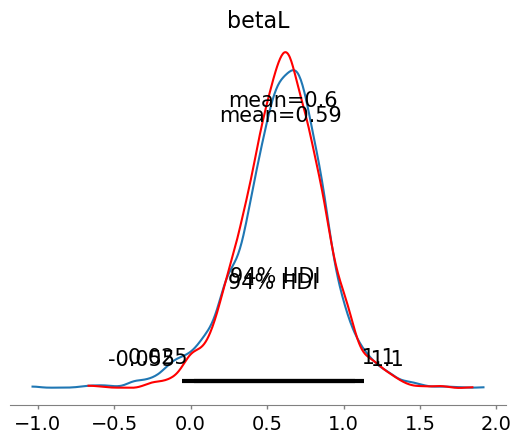

In [227]:
az.plot_posterior(test05.posterior.betaL)
az.plot_posterior(processtrace05.posterior.betaL,ax=plt.gca(),c="r")

# LAST WORKING VERSION (DO NOT BREAK)

In [350]:
def build_correlated_bias_model_OLD(
    rho_user,
    evidence: xr.DataArray,
    priors={},
    var_name="X"
):
    # coords from xarray
    model_names = np.unique(evidence.coords["model"].values)
    Ldata = len(evidence.values)
    nmodels=len(model_names)

    coords = {"model": model_names,"CMIP_run":np.arange(Ldata)}

    with pm.Model(coords=coords) as bias_model:

        # true value of the parameter we want to estimate
        if "X" in priors.keys():
            X_true = priors["X"](var_name)
        else:
            X_true=pm.Normal(var_name,0,100)

        # Structural uncertainty in CMIP
        if "sigma_struct" in priors.keys():
            sigma_struct = priors["sigma_struct"]("sigma_struct")
        else:
            sigma_struct = pm.HalfNormal("sigma_struct",1.0)

        # Internal variability
        if "sigma_iv" in priors.keys():
            sigma_m = priors["sigma_iv"]("sigma_iv")
        else:
            sigma_m = pm.HalfNormal("sigma_iv",1.,dims="model")
        # Force it into a tensorvariable if it's a scalar
        sigma_m = pt.as_tensor_variable(sigma_m)
        
        if rho_user == 0:
            # Independent latent X_m
            X_m = pm.Normal(
                f"{var_name}_CMIP",
                mu=X_true,
                sigma=sigma_struct,
                dims="model",
            )
        else:
            # Equicorrelation matrix
            I = pt.eye(nmodels)
            J = pt.ones((nmodels, nmodels))
            corr = (1 - rho_user) * I + rho_user * J

            # Cholesky factor
            chol = sigma_struct * pt.linalg.cholesky(corr)

            # Latent correlated model means
            X_m = pm.MvNormal(
                "X_m",
                mu=X_true * pt.ones(nmodels),
                chol=chol,
                dims="model",
            )
        
        for i,ESM in enumerate(coords["model"]):
            obs=evidence.sel(model=ESM).values
            if obs.shape == ():
                obs=[float(obs)]
            if len(sigma_m.shape.eval()) > 0:
                pm.Normal(f"X_{ESM}_lik",X_m[i],sigma_m[i],observed=evidence.sel(model=ESM).values)
            else:
                pm.Normal(f"X_{ESM}_lik",X_m[i],sigma_m,observed=evidence.sel(model=ESM).values)
            
        return bias_model   
            
            
            